In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/classification-of-math-problems-by-kasut-academy/sample_submission.csv
/kaggle/input/classification-of-math-problems-by-kasut-academy/train.csv
/kaggle/input/classification-of-math-problems-by-kasut-academy/test.csv


In [2]:
samp_subm_fPath = "/kaggle/input/classification-of-math-problems-by-kasut-academy/sample_submission.csv"
train_fPath = "/kaggle/input/classification-of-math-problems-by-kasut-academy/train.csv"
test_fPath = "/kaggle/input/classification-of-math-problems-by-kasut-academy/test.csv"
samp_subm_df = pd.read_csv(samp_subm_fPath, encoding="ISO-8859-1")
train = pd.read_csv(train_fPath, encoding='utf-8-sig')
test = pd.read_csv(test_fPath, encoding='utf-8-sig')


In [3]:
train.head()

,Question,label
0,A solitaire game is played as follows. Six di...,3
1,2. The school table tennis championship was he...,5
2,"Given that $x, y,$ and $z$ are real numbers th...",0
3,$25 \cdot 22$ Given three distinct points $P\l...,1
4,I am thinking of a five-digit number composed ...,5


In [4]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10189 entries, 0 to 10188
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  10189 non-null  object
 1   label     10189 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 159.3+ KB


In [5]:
test.head()

,id,Question
0,0,b'Solve 0 = -i - 91*i - 1598*i - 64220 for i.\n'
1,1,Galperin G.A.\n\nA natural number $N$ is 999.....
2,2,Example 7 Calculate $\frac{1}{2 \sqrt{1}+\sqrt...
3,3,"If $A$, $B$, and $C$ represent three distinct ..."
4,4,2. Calculate $1+12+123+1234+12345+123456+12345...


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3044 non-null   int64 
 1   Question  3044 non-null   object
dtypes: int64(1), object(1)
memory usage: 47.7+ KB


In [7]:
import re
import pandas as pd
import warnings
from sympy import sympify, SympifyError
from sympy.parsing.latex import parse_latex
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from collections import Counter
from typing import Dict, Union, Set, List, Optional, Tuple
import random
from transformers import BertTokenizer

# Download NLTK data (only needs to run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

class MathTextProcessor:
    def __init__(self, bert_tokenizer=None):
        self.tokenizer = bert_tokenizer
        self._init_patterns()
        self._init_special_tokens()
        if self.tokenizer:
            self._add_special_tokens()
    
    def _init_patterns(self):
        self.latex_pattern = re.compile(
            r'\$(?:\\\$|[^\$])*?\$|\\\(.*?\\\)|\\\[.*?\\\]|'
            r'\\begin\{equation\}.*?\\end\{equation\}|'
            r'\\begin\{align\}.*?\\end\{align\}|'
            r'\\[a-zA-Z]+\{.*?\}|\\[a-zA-Z]+\\?',
            re.DOTALL
        )
        
        self.math_symbols_map = {
            'bert': {
                r'\+': ' [PLUS] ',
                r'-': ' [MINUS] ',
                r'\*': ' [MUL] ',
                r'/': ' [DIV] ',
                r'=': ' [EQ] ',
                r'\^': ' [POW] ',
                r'<': ' [LT] ',
                r'>': ' [GT] ',
                r'\\leq': ' [LEQ] ',
                r'\\geq': ' [GEQ] ',
                r'\\times': ' [MUL] ',
                r'\\div': ' [DIV] ',
                r'\\cdot': ' [MUL] ',
                r'\\pm': ' [PLUSMINUS] ',
                r'\\mp': ' [MINUSPLUS] ',
            },
            'tfidf': {
                r'\+': ' plus ',
                r'-': ' minus ',
                r'\*': ' times ',
                r'/': ' divided_by ',
                r'=': ' equals ',
                r'\^': ' power ',
                r'<': ' less_than ',
                r'>': ' greater_than ',
                r'\\leq': ' less_or_equal ',
                r'\\geq': ' greater_or_equal ',
                r'\\times': ' times ',
                r'\\div': ' divided_by ',
                r'\\cdot': ' dot ',
                r'\\pm': ' plus_or_minus ',
                r'\\mp': ' minus_or_plus ',
            }
        }
        
        self.number_pattern = re.compile(r'\b\d+\.?\d*(?:[eE][+-]?\d+)?\b')
        self.whitespace_pattern = re.compile(r'\s+')
    
    def _init_special_tokens(self):
        self.special_tokens = [
            '[MATH]', '[PLUS]', '[MINUS]', '[MUL]', '[DIV]', '[EQ]', '[POW]',
            '[LT]', '[GT]', '[LEQ]', '[GEQ]', '[PLUSMINUS]', '[MINUSPLUS]',
            '[FIND]', '[NUMBER]', '[VALUE]', '[LET]', '[EQUATION]', '[POINTS]', 
            '[POSITIVE]', '[INTEGER]', '[TRIANGLE]', '[SUM]', '[SEQUENCE]', 
            '[ANGLE]', '[SQUARE]', '[DIGITS]', '[DIVISIBLE]', '[ROOTS]', 
            '[CIRCLE]', '[RADIUS]', '[PRODUCT]', '[EQUAL]', '[LINE]', '[DISTANCE]',
            '[TIME]', '[PROBABILITY]', '[PRIME]', '[DIGIT]', '[FIRST]', '[SECOND]',
            '[THIRD]', '[DISTINCT]', '[POINT]'
        ]
        
        self.keyword_to_token = {
            'find': '[FIND]',
            'number': '[NUMBER]',
            'value': '[VALUE]',
            'let': '[LET]',
            'equation': '[EQUATION]',
            'points': '[POINTS]',
            'positive': '[POSITIVE]',
            'integer': '[INTEGER]',
            'triangle': '[TRIANGLE]',
            'sum': '[SUM]',
            'sequence': '[SEQUENCE]',
            'angle': '[ANGLE]',
            'square': '[SQUARE]',
            'digits': '[DIGITS]',
            'digit': '[DIGIT]',
            'divisible': '[DIVISIBLE]',
            'roots': '[ROOTS]',
            'circle': '[CIRCLE]',
            'radius': '[RADIUS]',
            'product': '[PRODUCT]',
            'equal': '[EQUAL]',
            'line': '[LINE]',
            'distance': '[DISTANCE]',
            'time': '[TIME]',
            'probability': '[PROBABILITY]',
            'prime': '[PRIME]',
            'first': '[FIRST]',
            'second': '[SECOND]',
            'third': '[THIRD]',
            'distinct': '[DISTINCT]',
            'point': '[POINT]'
        }
    
    def _add_special_tokens(self):
        self.tokenizer.add_tokens(self.special_tokens)
    
    def preprocess_for_bert(self, text):
        if not isinstance(text, str):
            return ""
        
        text = self.latex_pattern.sub('[MATH]', text)
        
        for pattern, replacement in self.math_symbols_map['bert'].items():
            text = re.sub(pattern, replacement, text)
        
        for word, token in self.keyword_to_token.items():
            text = re.sub(r'\b' + word + r'\b', token, text, flags=re.IGNORECASE)
        
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s\[\]]', '', text)
        text = self.whitespace_pattern.sub(' ', text).strip()
        
        return text
    
    def preprocess_for_tfidf(self, text):
        if not isinstance(text, str):
            return ""
        
        text = self.latex_pattern.sub('math_expression', text)
        
        for pattern, replacement in self.math_symbols_map['tfidf'].items():
            text = re.sub(pattern, replacement, text)
        
        text = self.number_pattern.sub('number_token', text)
        
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s_]', '', text)
        text = self.whitespace_pattern.sub(' ', text).strip()
        
        return text
    
    def extract_keywords(self, text):
        if not isinstance(text, str):
            return ""
        
        tokens = text.lower().split()
        keywords = []
        
        for token in tokens:
            if token.startswith('[') and token.endswith(']'):
                keywords.append(token.upper())
            elif token in self.keyword_to_token:
                keywords.append(self.keyword_to_token[token])
        
        return ' '.join(keywords)
    
    def process_dataframe(self, df, text_column='Question'):
        df = df.copy()
        
        # Process text and keywords
        df['bert_text'] = df[text_column].apply(self.preprocess_for_bert)
        df['bert_keywords'] = df['bert_text'].apply(self.extract_keywords)
        
        df['tfidf_text'] = df[text_column].apply(self.preprocess_for_tfidf)
        df['tfidf_keywords'] = df['tfidf_text'].apply(self.extract_keywords)
        
        # Select only essential columns to keep
        keep_columns = [col for col in df.columns if not col.endswith('_features')]
        return df[keep_columns]

# Usage example:
processor = MathTextProcessor(BertTokenizer.from_pretrained('bert-base-uncased'))
train_processed = processor.process_dataframe(train)
test_processed = processor.process_dataframe(test)

# Verify the output columns
print(train_processed.columns)
# Output: ['Question', 'label', 'bert_text', 'bert_keywords', 'tfidf_text', 'tfidf_keywords']

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Index(['Question', 'label', 'bert_text', 'bert_keywords', 'tfidf_text',
       'tfidf_keywords'],
      dtype='object')


In [8]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer, 
    BertForSequenceClassification,
    BertModel,
    RobertaForSequenceClassification, 
    DebertaV2ForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from contextlib import nullcontext
import os
# ------------------------------
# Set seed for reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything()
num_epochs = 5
# ------------------------------
# Load your data
labeled_df = train_processed.copy()
unlabeled_df = test_processed.copy()

# ------------------------------
# Enhanced preprocessing using your specific columns
def preprocess_math_text(row):
    """Combine bert_text and bert_keywords for optimal BERT input"""
    text = str(row['bert_text'])
    keywords = str(row['bert_keywords'])
    if keywords and keywords != 'nan':
        text += f" [KEYWORDS] {keywords}"
    return text.strip()

# ------------------------------
# Class weights for imbalanced labels
label_distribution = {
    0: 0.2569, 1: 0.2394, 5: 0.1794, 4: 0.1681,
    2: 0.1020, 3: 0.0361, 6: 0.0098, 7: 0.0085
}
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
max_freq = max(label_distribution.values())
label_weights = [max_freq / label_distribution.get(i, 1e-6) for i in range(num_classes)]
class_weights = torch.tensor(label_weights, dtype=torch.float).to(device)

# ------------------------------
# Encode labels
label_encoder = LabelEncoder()
labeled_df['encoded_label'] = label_encoder.fit_transform(labeled_df['label'])
num_classes = len(label_encoder.classes_)
print(f"Encoded {num_classes} label classes")

# ------------------------------
# Initialize tokenizer with your special tokens
try:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    special_tokens = [
        '[MATH]', '[PLUS]', '[MINUS]', '[MUL]', '[DIV]', '[EQ]', '[POW]',
        '[FIND]', '[NUMBER]', '[VALUE]', '[LET]', '[EQUATION]', '[POINTS]', 
        '[POSITIVE]', '[INTEGER]', '[TRIANGLE]', '[SUM]', '[SEQUENCE]', 
        '[ANGLE]', '[SQUARE]', '[DIGITS]', '[DIVISIBLE]', '[ROOTS]', 
        '[CIRCLE]', '[RADIUS]', '[PRODUCT]', '[EQUAL]', '[LINE]', '[DISTANCE]',
        '[TIME]', '[KEYWORDS]'  # Added for keyword separation
    ]
    tokenizer.add_tokens(special_tokens)
    print(f"Tokenizer initialized with {len(special_tokens)} special tokens")
except Exception as e:
    print(f"Tokenizer init error: {e}")
    raise

# ------------------------------
# Dataset class optimized for your columns
class MathDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128, is_labeled=True):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_labeled = is_labeled
        
        # Preprocess all texts
        self.texts = df.apply(preprocess_math_text, axis=1).values
        self.labels = df['encoded_label'].values if is_labeled else None
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }
        
        if self.is_labeled:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
            
        return item

# ------------------------------
# Create datasets
# Split labeled data
train_df, val_df = train_test_split(
    labeled_df,
    test_size=0.1,
    random_state=42,
    stratify=labeled_df['encoded_label']
)

train_dataset = MathDataset(train_df, tokenizer)
val_dataset = MathDataset(val_df, tokenizer)

# For semi-supervised learning (if needed)
unlabeled_dataset = MathDataset(unlabeled_df, tokenizer, is_labeled=False) if len(unlabeled_df) > 0 else None

print("\nTraining Set Class Distribution:")
print(train_df['encoded_label'].value_counts(normalize=True))

print("\nValidation Set Class Distribution:")
print(val_df['encoded_label'].value_counts(normalize=True))

# ------------------------------
# Initialize model
try:
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=num_classes,
        ignore_mismatched_sizes=True
    )
    model.resize_token_embeddings(len(tokenizer))
    print(f"\nInitialized BERT model with {num_classes} output classes")
    print(f"Model vocab size: {model.config.vocab_size}")
except Exception as e:
    print(f"Model init error: {e}")
    raise

model = model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

class ModelPipeline:
    def __init__(self, train_loader, val_loader, tokenizer, device, num_labels=8):
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.tokenizer = tokenizer
        self.device = device
        self.num_labels = num_labels
        self.models = {}
        self.results = {}

    def _init_bert_cnn(self):
        """Complete working implementation of BERT-CNN"""
        class BertCNN(nn.Module):
            def __init__(self, num_labels, tokenizer):
                super().__init__()
                self.num_labels = num_labels  # Properly store num_labels
                self.tokenizer = tokenizer
                
                # Initialize BERT model
                self.bert = BertModel.from_pretrained('bert-base-uncased')
                self.bert.resize_token_embeddings(len(tokenizer))
                
                # CNN layers with proper initialization
                self.conv1 = nn.Conv1d(768, 256, kernel_size=3, padding=1)
                nn.init.kaiming_normal_(self.conv1.weight, mode='fan_out', nonlinearity='relu')
                self.conv2 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
                nn.init.kaiming_normal_(self.conv2.weight, mode='fan_out', nonlinearity='relu')
                
                # Classification head
                self.dropout = nn.Dropout(0.1)
                self.classifier = nn.Linear(128, num_labels)
                nn.init.xavier_normal_(self.classifier.weight)
            
            def forward(self, input_ids, attention_mask, labels=None):
                # BERT processing
                outputs = self.bert(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=False
                )
                sequence_output = outputs.last_hidden_state
                
                # CNN processing
                conv_input = sequence_output.permute(0, 2, 1)  # [batch, channels, seq_len]
                conv1_out = F.relu(self.conv1(conv_input))
                conv2_out = F.relu(self.conv2(conv1_out))
                
                # Global max pooling
                pooled = torch.max(conv2_out, dim=2)[0]
                pooled = self.dropout(pooled)
                
                logits = self.classifier(pooled)
                
                loss = None
                if labels is not None:
                    loss_fct = nn.CrossEntropyLoss()
                    loss = loss_fct(logits.view(-1, self.num_labels), 
                                  labels.view(-1))
                
                return {'loss': loss, 'logits': logits}
        
        return BertCNN(num_labels=self.num_labels, tokenizer=self.tokenizer)

    def initialize_models(self):
        """Initialize all models with verification"""
        print("\nInitializing models...")
        
        # Initialize BERT-CNN first with verification
        try:
            self.models['bert-cnn'] = self._init_bert_cnn()
            print("✓ BERT-CNN initialized successfully")
            print(f"  Parameters: {sum(p.numel() for p in self.models['bert-cnn'].parameters()):,}")
        except Exception as e:
            print(f"✗ BERT-CNN initialization failed: {e}")
            raise
        
        # Other models
        model_configs = [
            ('bert-base', 'bert-base-uncased', BertForSequenceClassification),
            ('roberta-base', 'roberta-base', RobertaForSequenceClassification),
            ('deberta-base', 'microsoft/deberta-v3-base', DebertaV2ForSequenceClassification),
            ('bert-large', 'bert-large-uncased', BertForSequenceClassification)
        ]
        
        for name, pretrained_name, model_class in model_configs:
            try:
                self.models[name] = model_class.from_pretrained(
                    pretrained_name,
                    num_labels=self.num_labels,
                    ignore_mismatched_sizes=True
                )
                if hasattr(self.models[name], 'resize_token_embeddings'):
                    self.models[name].resize_token_embeddings(len(self.tokenizer))
                print(f"✓ {name} initialized successfully")
                print(f"  Parameters: {sum(p.numel() for p in self.models[name].parameters()):,}")
            except Exception as e:
                print(f"✗ {name} initialization failed: {e}")
                continue
        
        # Move all models to device
        for name, model in self.models.items():
            model.to(self.device)
            print(f"  {name} moved to {self.device}")

    def train_model(self, model, model_name, epochs=num_epochs):
        """Robust training with verification"""
        print(f"\nTraining {model_name}...")
        
        # Verify model attributes
        if not hasattr(model, 'num_labels'):
            model.num_labels = self.num_labels
        
        optimizer = AdamW(model.parameters(), lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=100,
            num_training_steps=len(self.train_loader) * epochs
        )
        
        best_val_acc = 0
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            
            for batch in tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                optimizer.zero_grad()
                
                # Verify input shapes
                inputs = {
                    'input_ids': batch['input_ids'].to(self.device),
                    'attention_mask': batch['attention_mask'].to(self.device),
                    'labels': batch['labels'].to(self.device)
                }
                
                outputs = model(**inputs)
                loss = outputs['loss']
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                
                total_loss += loss.item()
            
            # Validation
            val_acc, val_f1 = self.evaluate_model(model)
            avg_loss = total_loss / len(self.train_loader)
            
            print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f} - Val Acc: {val_acc:.4f} - Val F1: {val_f1:.4f}")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), f"best_{model_name}.pt")
                print(f"Saved best {model_name} model")
        
        return best_val_acc
        
    def _train_large_model(self, model, model_name, epochs):
        """Special training procedure for BERT-large"""
        print("Applying memory optimizations for BERT-large...")
        
        # Enable gradient checkpointing
        model.gradient_checkpointing_enable()
        
        # Use mixed precision training
        scaler = torch.cuda.amp.GradScaler()
        
        # Gradient accumulation (process 4 batches before updating)
        accumulation_steps = 4
        optimizer = AdamW(model.parameters(), lr=1e-5)  # Slightly lower learning rate
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=50,  # Reduced warmup
            num_training_steps=(len(self.train_loader) * epochs) // accumulation_steps
        )
        
        best_val_acc = 0
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            optimizer.zero_grad()
            
            for i, batch in enumerate(tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
                inputs = {
                    'input_ids': batch['input_ids'].to(self.device),
                    'attention_mask': batch['attention_mask'].to(self.device),
                    'labels': batch['labels'].to(self.device)
                }
                
                # Mixed precision forward pass
                with torch.autocast(device_type='cuda', dtype=torch.float16):
                    outputs = model(**inputs)
                    loss = outputs['loss'] / accumulation_steps
                
                # Scaled backward pass
                scaler.scale(loss).backward()
                total_loss += loss.item() * accumulation_steps
                
                # Only update weights every accumulation_steps batches
                if (i + 1) % accumulation_steps == 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    scheduler.step()
            
            # Final validation
            val_acc, val_f1 = self.evaluate_model(model)
            avg_loss = total_loss / len(self.train_loader)
            
            print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f} - Val Acc: {val_acc:.4f} - Val F1: {val_f1:.4f}")
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), f"best_{model_name}.pt")
                print(f"Saved best {model_name} model")
        
        return best_val_acc
        
    def evaluate_model(self, model):
        """Evaluation with optional mixed precision for large models"""
        model.eval()
        predictions = []
        true_labels = []
        
        # Use autocast only for large models
        eval_context = torch.autocast(device_type='cuda', dtype=torch.float16) if isinstance(model, BertForSequenceClassification) and model.config.hidden_size > 768 else nullcontext()
        
        with torch.no_grad(), eval_context:
            for batch in self.val_loader:
                inputs = {
                    'input_ids': batch['input_ids'].to(self.device),
                    'attention_mask': batch['attention_mask'].to(self.device)
                }
                labels = batch['labels'].to(self.device)
                
                outputs = model(**inputs)
                preds = torch.argmax(outputs['logits'], dim=1)
                
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        
        acc = accuracy_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions, average='weighted')
        return acc, f1
    
    def run_pipeline(self, epochs=num_epochs):
        """Run pipeline starting with BERT-large first"""
        self.initialize_models()
        
        # Check if BERT-large exists and train it first with memory optimizations
        if 'bert-large' in self.models:
            print(f"\n{'='*40}")
            print(f"Training bert-large model FIRST")
            print(f"{'='*40}")
            
            model = self.models['bert-large']
            best_acc = self._train_large_model(model, 'bert-large', epochs)
            val_acc, val_f1 = self.evaluate_model(model)
            
            self.results['bert-large'] = {
                'accuracy': val_acc,
                'f1_score': val_f1,
                'model': model
            }
            
            # Free up memory after BERT-large training
            del model
            torch.cuda.empty_cache()
        
        # Then train other models
        for name, model in self.models.items():
            if name == 'bert-large':  # Skip since we already trained it
                continue
                
            print(f"\n{'='*40}")
            print(f"Training {name} model")
            print(f"{'='*40}")
            
            best_acc = self.train_model(model, name, epochs)
            val_acc, val_f1 = self.evaluate_model(model)
            
            self.results[name] = {
                'accuracy': val_acc,
                'f1_score': val_f1,
                'model': model
            }
            
        # Select best model
        best_model_name = max(self.results.items(), key=lambda x: x[1]['accuracy'])[0]
        print(f"\nBest model: {best_model_name}")
        print(f"Accuracy: {self.results[best_model_name]['accuracy']:.4f}")
        print(f"F1 Score: {self.results[best_model_name]['f1_score']:.4f}")
        
        return self.results[best_model_name]['model']


os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  # For better error messages

try:
    print("Initializing pipeline...")
    pipeline = ModelPipeline(
        train_loader=train_loader,
        val_loader=val_loader,
        tokenizer=tokenizer,
        device=device,
        num_labels=num_classes
    )
    
    print("\nRunning pipeline...")
    best_model = pipeline.run_pipeline(epochs=num_epochs)
    
    print("\nPipeline completed successfully!")
    print(f"Best model: {type(best_model).__name__}")
    
except Exception as e:
    print(f"\nPipeline failed: {str(e)}")
    print("\nDebugging info:")
    print(f"- Device: {device}")
    print(f"- Num labels: {num_classes}")
    print(f"- Tokenizer vocab size: {len(tokenizer)}")
    if 'pipeline' in locals():
        print("\nModel initialization status:")
        for name, model in pipeline.models.items():
            status = "Initialized" if model is not None else "Failed"
            print(f"  {name}: {status}")


2025-05-03 20:02:23.974083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746302544.196842      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746302544.259511      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Encoded 8 label classes
Tokenizer initialized with 31 special tokens


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`



Training Set Class Distribution:
encoded_label
0    0.256925
1    0.239368
5    0.179280
4    0.168048
2    0.101963
3    0.036096
6    0.009815
7    0.008506
Name: proportion, dtype: float64

Validation Set Class Distribution:
encoded_label
0    0.257115
1    0.239450
5    0.179588
4    0.167812
2    0.102061
3    0.036310
6    0.009814
7    0.007851
Name: proportion, dtype: float64


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`



Initialized BERT model with 8 output classes
Model vocab size: 30553
Initializing pipeline...

Running pipeline...

Initializing models...
✓ BERT-CNN initialized successfully
  Parameters: 110,195,592


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ bert-base initialized successfully
  Parameters: 109,512,200


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ roberta-base initialized successfully
  Parameters: 109,512,968


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ deberta-base initialized successfully
  Parameters: 109,512,200


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ bert-large initialized successfully
  Parameters: 335,181,832
  bert-cnn moved to cuda
  bert-base moved to cuda
  roberta-base moved to cuda
  deberta-base moved to cuda


/tmp/ipykernel_19/2382077345.py:331: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


  bert-large moved to cuda

Training bert-large model FIRST
Applying memory optimizations for BERT-large...


Epoch 1/5: 100%|██████████| 574/574 [03:45<00:00,  2.55it/s]


Epoch 1 - Loss: 1.5409 - Val Acc: 0.6987 - Val F1: 0.6943
Saved best bert-large model


Epoch 2/5: 100%|██████████| 574/574 [03:50<00:00,  2.49it/s]


Epoch 2 - Loss: 0.7741 - Val Acc: 0.7537 - Val F1: 0.7521
Saved best bert-large model


Epoch 3/5: 100%|██████████| 574/574 [03:50<00:00,  2.49it/s]


Epoch 3 - Loss: 0.6011 - Val Acc: 0.7753 - Val F1: 0.7741
Saved best bert-large model


Epoch 4/5: 100%|██████████| 574/574 [03:50<00:00,  2.49it/s]


Epoch 4 - Loss: 0.5057 - Val Acc: 0.7733 - Val F1: 0.7740


Epoch 5/5: 100%|██████████| 574/574 [03:50<00:00,  2.49it/s]


Epoch 5 - Loss: 0.4458 - Val Acc: 0.7802 - Val F1: 0.7786
Saved best bert-large model

Training bert-cnn model

Training bert-cnn...


Epoch 1/5: 100%|██████████| 574/574 [03:41<00:00,  2.59it/s]


Epoch 1 - Loss: 1.4553 - Val Acc: 0.7547 - Val F1: 0.7555
Saved best bert-cnn model


Epoch 2/5: 100%|██████████| 574/574 [03:40<00:00,  2.61it/s]


Epoch 2 - Loss: 0.6371 - Val Acc: 0.7694 - Val F1: 0.7672
Saved best bert-cnn model


Epoch 3/5: 100%|██████████| 574/574 [03:40<00:00,  2.61it/s]


Epoch 3 - Loss: 0.4555 - Val Acc: 0.7763 - Val F1: 0.7742
Saved best bert-cnn model


Epoch 4/5: 100%|██████████| 574/574 [03:39<00:00,  2.61it/s]


Epoch 4 - Loss: 0.3205 - Val Acc: 0.7674 - Val F1: 0.7662


Epoch 5/5: 100%|██████████| 574/574 [03:39<00:00,  2.61it/s]


Epoch 5 - Loss: 0.2303 - Val Acc: 0.7743 - Val F1: 0.7740

Training bert-base model

Training bert-base...


Epoch 1/5: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]


Epoch 1 - Loss: 1.0680 - Val Acc: 0.7655 - Val F1: 0.7649
Saved best bert-base model


Epoch 2/5: 100%|██████████| 574/574 [03:33<00:00,  2.68it/s]


Epoch 2 - Loss: 0.5870 - Val Acc: 0.7792 - Val F1: 0.7819
Saved best bert-base model


Epoch 3/5: 100%|██████████| 574/574 [03:33<00:00,  2.68it/s]


Epoch 3 - Loss: 0.4090 - Val Acc: 0.7841 - Val F1: 0.7829
Saved best bert-base model


Epoch 4/5: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]


Epoch 4 - Loss: 0.2871 - Val Acc: 0.7861 - Val F1: 0.7856
Saved best bert-base model


Epoch 5/5: 100%|██████████| 574/574 [03:33<00:00,  2.68it/s]


Epoch 5 - Loss: 0.2092 - Val Acc: 0.7841 - Val F1: 0.7845

Training roberta-base model

Training roberta-base...


Epoch 1/5: 100%|██████████| 574/574 [03:33<00:00,  2.68it/s]


Epoch 1 - Loss: 1.2851 - Val Acc: 0.6722 - Val F1: 0.6599
Saved best roberta-base model


Epoch 2/5: 100%|██████████| 574/574 [03:33<00:00,  2.68it/s]


Epoch 2 - Loss: 0.8674 - Val Acc: 0.7360 - Val F1: 0.7294
Saved best roberta-base model


Epoch 3/5: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]


Epoch 3 - Loss: 0.7041 - Val Acc: 0.7370 - Val F1: 0.7279
Saved best roberta-base model


Epoch 4/5: 100%|██████████| 574/574 [03:34<00:00,  2.68it/s]


Epoch 4 - Loss: 0.5767 - Val Acc: 0.7458 - Val F1: 0.7398
Saved best roberta-base model


Epoch 5/5: 100%|██████████| 574/574 [03:33<00:00,  2.68it/s]


Epoch 5 - Loss: 0.4839 - Val Acc: 0.7605 - Val F1: 0.7567
Saved best roberta-base model

Training deberta-base model

Training deberta-base...


Epoch 1/5: 100%|██████████| 574/574 [04:28<00:00,  2.14it/s]


Epoch 1 - Loss: 1.4361 - Val Acc: 0.5888 - Val F1: 0.5560
Saved best deberta-base model


Epoch 2/5: 100%|██████████| 574/574 [04:27<00:00,  2.15it/s]


Epoch 2 - Loss: 1.0609 - Val Acc: 0.6869 - Val F1: 0.6810
Saved best deberta-base model


Epoch 3/5: 100%|██████████| 574/574 [04:27<00:00,  2.15it/s]


Epoch 3 - Loss: 0.9285 - Val Acc: 0.7154 - Val F1: 0.7111
Saved best deberta-base model


Epoch 4/5: 100%|██████████| 574/574 [04:27<00:00,  2.15it/s]


Epoch 4 - Loss: 0.8176 - Val Acc: 0.7311 - Val F1: 0.7281
Saved best deberta-base model


Epoch 5/5: 100%|██████████| 574/574 [04:27<00:00,  2.15it/s]


Epoch 5 - Loss: 0.7450 - Val Acc: 0.7448 - Val F1: 0.7410
Saved best deberta-base model

Best model: bert-base
Accuracy: 0.7841
F1 Score: 0.7845

Pipeline completed successfully!
Best model: BertForSequenceClassification


Evaluating on the full labeled dataset...


Evaluating Full Labeled Set: 100%|██████████| 637/637 [01:21<00:00,  7.81it/s]



Full Labeled Dataset Performance:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2618
           1       0.98      0.95      0.96      2439
           2       0.90      0.92      0.91      1039
           3       0.97      0.98      0.98       368
           4       0.95      0.95      0.95      1712
           5       0.97      0.94      0.96      1827
           6       0.93      0.51      0.66       100
           7       0.89      0.91      0.90        86

    accuracy                           0.94     10189
   macro avg       0.94      0.89      0.91     10189
weighted avg       0.94      0.94      0.94     10189


Weighted F1 Score: 0.9430

Label Distribution Comparison (Full Dataset):
   True Distribution  Predicted Distribution  Expected Distribution
0           0.256944                0.270095                 0.2569
1           0.239376                0.231819                 0.2394
2           0.101973                

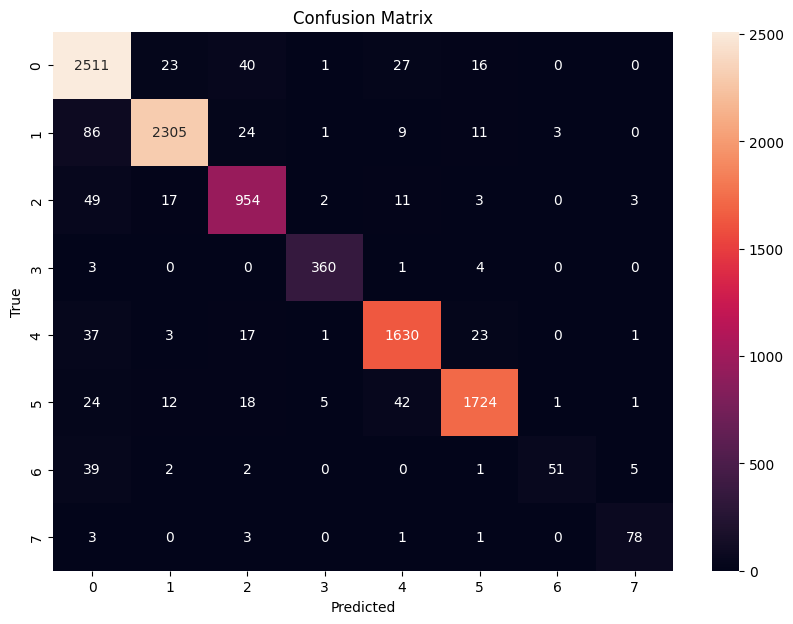


Predicting labels for unlabeled data...


Predicting Unlabeled Data: 100%|██████████| 191/191 [00:24<00:00,  7.88it/s]


Sample predictions:
   id  label
0   0      0
1   1      4
2   2      2
3   3      4
4   4      4

Predictions saved to unlabeled_predictions.csv


In [9]:
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------------------------
# 1. Evaluate on FULL labeled dataset
print("Evaluating on the full labeled dataset...")

# Prepare dataset for full labeled data (using best_model from pipeline)
full_labeled_dataset = MathDataset(
    labeled_df,  # Pass the DataFrame directly
    tokenizer
)
full_labeled_loader = DataLoader(full_labeled_dataset, batch_size=16)

# Use the best model from the pipeline instead of loading from file
best_model.eval()

full_preds = []
full_true = []

with torch.no_grad():
    for batch in tqdm(full_labeled_loader, desc="Evaluating Full Labeled Set"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Handle both dict and standard model outputs
        outputs = best_model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get logits from either format
        if isinstance(outputs, dict):
            logits = outputs['logits']
        else:
            logits = outputs.logits
            
        _, preds = torch.max(logits, dim=1)
        
        full_preds.extend(preds.cpu().numpy())
        full_true.extend(labels.cpu().numpy())

full_true_decoded = label_encoder.inverse_transform(full_true)
full_preds_decoded = label_encoder.inverse_transform(full_preds)

print("\nFull Labeled Dataset Performance:")
print("="*50)
print(classification_report(full_true_decoded, full_preds_decoded))

full_weighted_f1 = f1_score(full_true_decoded, full_preds_decoded, average='weighted')
print(f"\nWeighted F1 Score: {full_weighted_f1:.4f}")

# ------------------------------
# 2. Compare label distributions
true_dist = pd.Series(full_true_decoded).value_counts(normalize=True).sort_index()
pred_dist = pd.Series(full_preds_decoded).value_counts(normalize=True).sort_index()

dist_df = pd.DataFrame({
    'True Distribution': true_dist,
    'Predicted Distribution': pred_dist,
    'Expected Distribution': pd.Series(label_distribution)
}).fillna(0)

print("\nLabel Distribution Comparison (Full Dataset):")
print(dist_df)

# Optional: Plot confusion matrix
conf_matrix = confusion_matrix(full_true_decoded, full_preds_decoded, labels=label_encoder.classes_)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ------------------------------
# 3. Predict on unlabeled data (updated version)
def predict_unlabeled(df, model, tokenizer, label_encoder, batch_size=16):
    """Predict labels for unlabeled data using the best model"""
    model.eval()
    predictions = []
    
    # Create dataset (automatically uses preprocess_math_text)
    dataset = MathDataset(
        df,
        tokenizer,
        is_labeled=False  # No labels needed
    )
    loader = DataLoader(dataset, batch_size=batch_size)

    with torch.no_grad():
        for batch in tqdm(loader, desc="Predicting Unlabeled Data"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Handle both dict and standard model outputs
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Get logits from either format
            if isinstance(outputs, dict):
                logits = outputs['logits']
            else:
                logits = outputs.logits
                
            _, preds = torch.max(logits, dim=1)
            predictions.extend(preds.cpu().numpy())

    return label_encoder.inverse_transform(predictions)

# Apply to unlabeled data
print("\nPredicting labels for unlabeled data...")
unlabeled_df['label'] = predict_unlabeled(
    unlabeled_df, 
    best_model, 
    tokenizer, 
    label_encoder
)

# Show some examples
print("\nSample predictions:")
print(unlabeled_df[['id', 'label']].head())

# Save predictions
if 'id' in unlabeled_df.columns:
    unlabeled_df[['id', 'label']].to_csv('unlabeled_predictions.csv', index=False)
    print("\nPredictions saved to unlabeled_predictions.csv")
else:
    unlabeled_df['label'].to_csv('predictions.csv', index=False)
    print("\nPredictions saved to predictions.csv")